In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

import time

from sklearn.metrics import mean_absolute_error

In [ ]:
limit_ListPrice = 1800
price_segment = 30
customer_traffic_segment = 0.0833 #5/(limit_ListPrice/price_segment)
competitiveness_segment = 0.0416 #2.5/(limit_ListPrice/price_segment)
epsilon = 0.4

# Dynamic Pricing with Reinforcement Learning

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/dynamic_pricing/data/preprocessed_data_v3_training.csv")
df_val = pd.read_csv("/content/drive/My Drive/Colab Notebooks/dynamic_pricing/data/preprocessed_data_v3_validation.csv")

RANDOM OTEL GRUPLARI

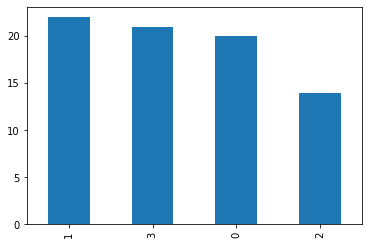

In [ ]:
random = pd.DataFrame({'DWHotelID':df.DWHotelID.unique()})
random['random'] = np.random.randint(0, 4, random.shape[0])
random['random'].value_counts().plot(kind='bar')


In [ ]:
df = pd.merge(df, random, on="DWHotelID")
df_val = pd.merge(df_val, random, on="DWHotelID")

In [ ]:
df_byrandom_train2 = []
df_byrandom_val2 = []
for i in df.random.unique():
    df_byrandom_train2.append(df.loc[df['random']==i])
    df_byrandom_val2.append(df_val.loc[df_val['random']==i])

In [45]:
print("\n***************************************************\nTraining\n***************************************************\n")
df_byrandom_train=[]
for df in df_byrandom_train2:
    df = df[df['ListPriceTRY']<=limit_ListPrice]
    df = df[df['PurchaseAmountTRY']<=limit_ListPrice]
    print('------------------------------------------------------------------------')
    print('Max Purchase Amount:', df['PurchaseAmountTRY'].max() , 'Min Purchase Amount:', df['PurchaseAmountTRY'].min())
    print('Max List Price:', df['ListPriceTRY'].max() , 'Min List Price:', df['ListPriceTRY'].min() )
    print('Max Rate:', df['RatingTripA'].max(), 'Min Rate:', df['RatingTripA'].min())
    print('Max Feature Score:', df['featureScore'].max() , 'Min Feature Score:', df['featureScore'].min())
    print('Max Room Count:', df['empty_rooms'].max() , 'Min Room Count:', df['empty_rooms'].min())
    print('------------------------------------------------------------------------')
    df_byrandom_train.append(df)
print("\n***************************************************\nValidation\n***************************************************\n")
df_byrandom_val=[]
for df in df_byrandom_val2:
    df = df[df['ListPriceTRY']<=limit_ListPrice]
    df = df[df['PurchaseAmountTRY']<=limit_ListPrice]
    print('------------------------------------------------------------------------')
    print('Max Purchase Amount:', df['PurchaseAmountTRY'].max() , 'Min Purchase Amount:', df['PurchaseAmountTRY'].min())
    print('Max List Price:', df['ListPriceTRY'].max() , 'Min List Price:', df['ListPriceTRY'].min() )
    print('Max Rate:', df['RatingTripA'].max(), 'Min Rate:', df['RatingTripA'].min())
    print('Max Feature Score:', df['featureScore'].max() , 'Min Feature Score:', df['featureScore'].min())
    print('Max Room Count:', df['empty_rooms'].max() , 'Min Room Count:', df['empty_rooms'].min())
    print('------------------------------------------------------------------------')
    df_byrandom_val.append(df)



***************************************************
Training
***************************************************

------------------------------------------------------------------------
Max Purchase Amount: 1660.5 Min Purchase Amount: 34.0
Max List Price: 1800.0 Min List Price: 37.66666666666666
Max Rate: 4.5 Min Rate: 2.5
Max Feature Score: 2.03049406885924 Min Feature Score: 0.469892026578073
Max Room Count: 488.001 Min Room Count: 0.001
------------------------------------------------------------------------
------------------------------------------------------------------------
Max Purchase Amount: 1610.0 Min Purchase Amount: 90.0
Max List Price: 1798.0 Min List Price: 108.0
Max Rate: 4.5 Min Rate: 3.5
Max Feature Score: 2.2538542161050463 Min Feature Score: 0.4794817905629089
Max Room Count: 391.001 Min Room Count: 0.001
------------------------------------------------------------------------
------------------------------------------------------------------------
Max Purchase 

### UTILITY FUNCTIONS

In [ ]:
def round_specific(x, precision, base):
  return round(base * round(float(x)/base),precision)

def round_specific_series(x, precision, base):
  return round(base * round(x/base),precision)

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def print_metrics(data_frame):
    
  print("*Number of Sales: ",data_frame.shape[0])
  print("*Mean Absolute Error: ", mean_absolute_error(data_frame['ListPriceTRY'],data_frame['list_price']));
 
  print("*Mean Absolute Percentage Error ", mean_absolute_percentage_error(data_frame['ListPriceTRY'],data_frame['list_price']));
 
  print("*Mean of Recommended List Prices:", data_frame['list_price'].mean())
  print("*Mean of Original List Prices:", data_frame['ListPriceTRY'].mean())

  print("*Standard Deviation of Recommended List Prices:", data_frame['list_price'].std())
  print("*Standard Deviation of Original List Prices:", data_frame['ListPriceTRY'].std())
 
  return

#### Reward Functions

In [ ]:
def proposed(list_price, purchase, empty_rooms):
    return (list_price-purchase)/empty_rooms
def timestamp(list_price, purchase, empty_rooms,list_price2, purchase2, empty_rooms2):
    return (list_price2-purchase2)/empty_rooms2 - (list_price-purchase)/empty_rooms
def profit(list_price,purchase):
    return (list_price-purchase)/(purchase+0.001)

#### Draw Functions

In [ ]:
def draw(moving_avg, moving_avg_val, moving_avg_all, df, validation):
    print("Validation")
    plt.rcParams['figure.figsize'] = [20, 5]
    plt.plot([i for i in range(len(moving_avg_val))], moving_avg_val)
    plt.ylabel(f"Reward 100ma")
    plt.xlabel("episode #")
    plt.show()

    validation.reset_index()
    validation = validation[['ListPriceTRY','list_price']]
    plt.figure();
    plt.rcParams['figure.figsize'] = [20, 5]
    validation.plot.area(stacked=False);
    plt.show()
    

    print("All Dataset")
    plt.rcParams['figure.figsize'] = [20, 5]
    plt.plot([i for i in range(len(moving_avg_all))],moving_avg_all)
    plt.ylabel(f"Reward 100ma")
    plt.xlabel("episode #")
    plt.show()

    df2 = pd.concat([df,validation])
    df22 = df2[['ListPriceTRY','list_price']]
    plt.figure();
    plt.rcParams['figure.figsize'] = [20, 5]
    df22.plot.area(stacked=False);
    plt.show()
    print("\n\n\|")
    print_metrics(validation)
    print("|")
    print_metrics(df2)
    print("|")
    print_metrics(df)

### AGENT CLASS: SALE
 * Initializes first list price according to purchase amount
 * Takes actions: +10%, 0, -5%

In [ ]:
class Sale:
    def __init__(self, purchase, customer_traffic, competitiveness, empty_rooms):
        self.profit = round_specific(np.random.rand()*0.2, 2, 0.01)
        self.purchase = purchase
        if self.purchase > limit_ListPrice:
            self.purchase = limit_ListPrice
        if self.purchase < 0:
            self.purchase = 0
        
        self.list_price = self.purchase + self.purchase*self.profit
        self.list_price = round_specific(self.list_price, 0, price_segment)
        if self.list_price > limit_ListPrice:
            self.list_price = limit_ListPrice
        if self.list_price < 0:
            self.list_price = 0

        self.customer_traffic = customer_traffic
        self.competitiveness = competitiveness
        self.empty_rooms = empty_rooms
    
    def __str__(self):
        return f"{self.profit}"
    
    def __sub__(self,other):
        return self.profit - other.profit
    
    def action(self, choice):
        if choice == 0:
            self.change(-5) # profiti %5 indir
        elif choice == 1:
            self.change(0) 
        elif choice == 2:
            self.change(+10) 
        """
        elif choice == 3:
            self.change(+5) 
        elif choice == 4:
            self.change(+10) # profiti %10 arttir 
        """
    
    def change(self, p=False):
        if not p:
            self.profit = round_specific(np.random.rand(), 2, 0.01)
        else:
            self.profit = self.profit + (p/100)
            
        self.list_price = self.purchase + self.purchase*self.profit 
        self.list_price = round_specific(self.list_price, 0, price_segment)
        if self.list_price > limit_ListPrice:
            self.list_price = limit_ListPrice
        if self.list_price < 0:
            self.list_price = 0

### LOAD Q TABLE

In [ ]:
q_table_main = np.load('/content/drive/My Drive/Colab Notebooks/dynamic_pricing/data/qtable/q_table_30_1800_3acts.npy',allow_pickle='TRUE').item()

### RL FUNCTIONS

#### 1- RL WITH PROPOSED REWARD FUNCTION

In [ ]:
def RL_proposed(HM_EPISODES, epsilon, df, q_table):
    EPS_DECAY = 0.998
    SHOW_EVERY = 1
    LEARNING_RATE = 0.1
    DISCOUNT = 0.95
    df['list_price']=np.nan

    episode_rewards = []

    for episode in range(HM_EPISODES):
        # initalize agent
        sale = df.iloc[episode]
        
        purchase = sale['PurchaseAmountTRY']
        purchase = round_specific(purchase, 0, price_segment)
        
        customer_traffic = sale['RatingTripA']
        customer_traffic = round_specific(customer_traffic, 1, customer_traffic_segment)
        
        competitiveness = sale['featureScore']
        competitiveness = round_specific(competitiveness, 2, competitiveness_segment)
        
        empty_rooms = sale['empty_rooms']
        
        # get first list price 
        agent = Sale(purchase, customer_traffic, competitiveness, empty_rooms)
        
        list_price = agent.list_price

        episode_reward = 0

        for i in range(200):
            obs = (purchase, list_price, customer_traffic, competitiveness)
            
            if np.random.random() > epsilon:
                # GET THE ACTION
                action = np.argmax(q_table[obs])
            else:
                action = np.random.randint(0, 3)
            
            # Take the action!
            agent.action(action)
            
            ##############################
            # REWARD FUNCTION
            new_obs = (agent.purchase, agent.list_price, agent.customer_traffic, agent.competitiveness)
            max_future_q = np.max(q_table[new_obs])
   
            current_q = q_table[obs][action]
            
            rewardrate = proposed(agent.list_price, agent.purchase,agent.empty_rooms)
            
            if rewardrate < 1:
                reward = -300
                new_q = (1 - LEARNING_RATE) * current_q + LEARNING_RATE * (reward + DISCOUNT * max_future_q)
            elif rewardrate < 10 or rewardrate > 100:
                new_q = rewardrate
                reward = 25
            else:
                reward = -1
                new_q = (1 - LEARNING_RATE) * current_q + LEARNING_RATE * (reward + DISCOUNT * max_future_q)
            
            q_table[obs][action] = new_q

            episode_reward += reward
            if reward ==25:
                break
        df['list_price'].iloc[episode] = agent.list_price
        #print(episode_reward)
        episode_rewards.append(episode_reward)
        epsilon *= EPS_DECAY

    moving_avg = np.convolve(episode_rewards, np.ones((SHOW_EVERY,))/SHOW_EVERY, mode='valid')
    return df, moving_avg

#### RUN RL ALGORITHMS

In [ ]:
moving_avg_random= {
  "random0": [],
  "random1": [],
  "random2": [],
  "random3": [],
  "randomall": [],
}

### DRAW AND PRINT METRICS

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Validation


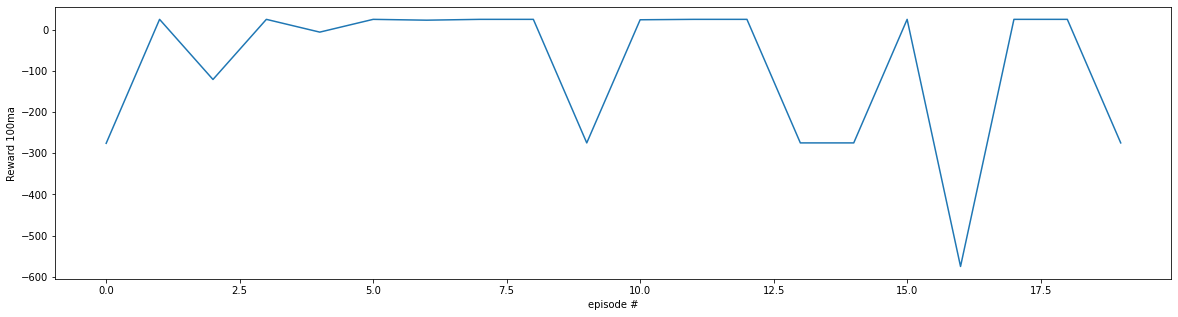

<Figure size 1440x360 with 0 Axes>

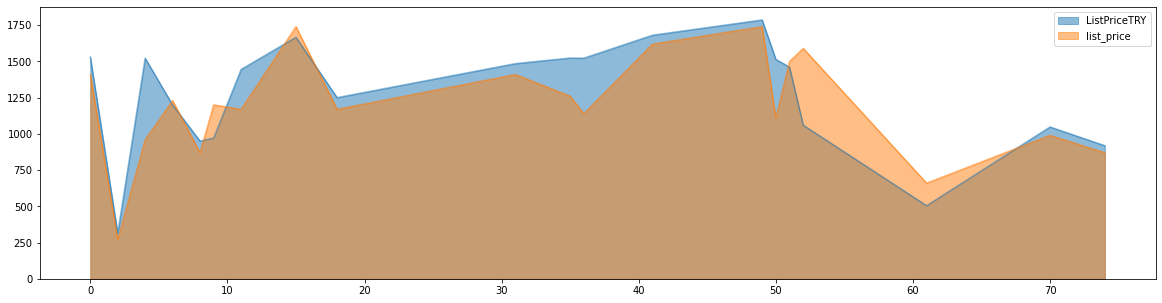

All Dataset


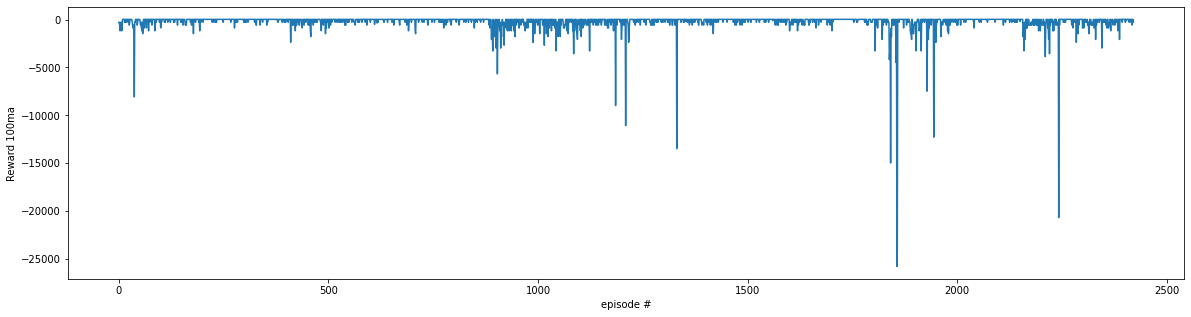

<Figure size 1440x360 with 0 Axes>

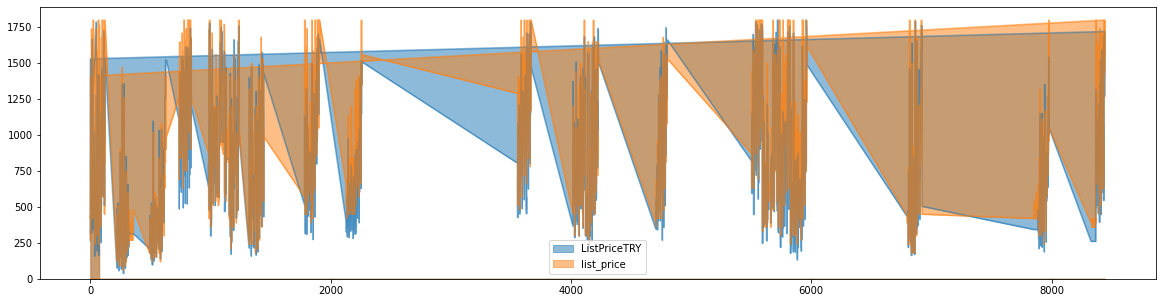



\|
*Number of Sales:  20
*Mean Absolute Error:  177.80306354752543
*Mean Absolute Percentage Error  14.884231488396187
*Mean of Recommended List Prices: 1195.5
*Mean of Original List Prices: 1267.6337638276373
*Standard Deviation of Recommended List Prices: 368.7457403857454
*Standard Deviation of Original List Prices: 393.2873459680791
|
*Number of Sales:  2421
*Mean Absolute Error:  123.64336274571028
*Mean Absolute Percentage Error  19.702384474945987
*Mean of Recommended List Prices: 822.3543990086741
*Mean of Original List Prices: 754.9955191986292
*Standard Deviation of Recommended List Prices: 420.00195784945635
*Standard Deviation of Original List Prices: 415.78277927877906
|
*Number of Sales:  2401
*Mean Absolute Error:  123.19221988188842
*Mean Absolute Percentage Error  19.74251902710384
*Mean of Recommended List Prices: 819.2461474385673
*Mean of Original List Prices: 750.7253130792706
*Standard Deviation of Recommended List Prices: 419.0766315797062
*Standard Deviation o

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Validation


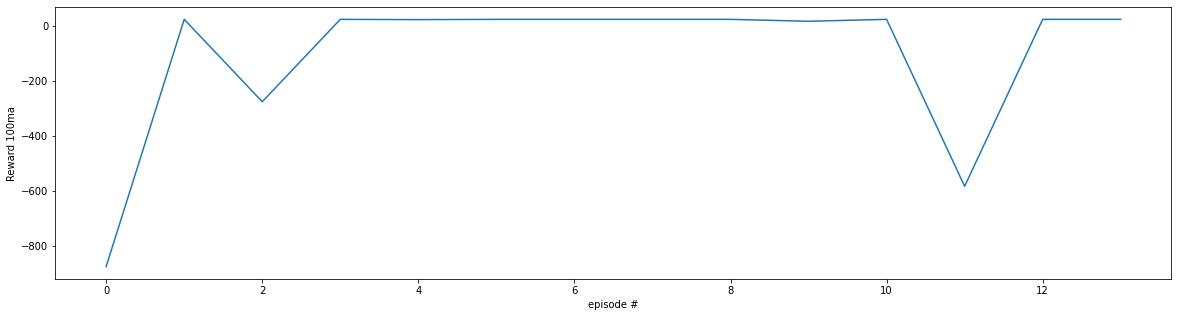

<Figure size 1440x360 with 0 Axes>

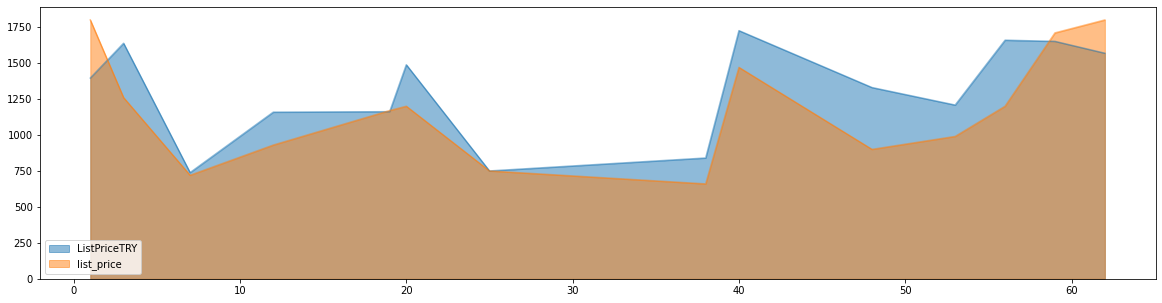

All Dataset


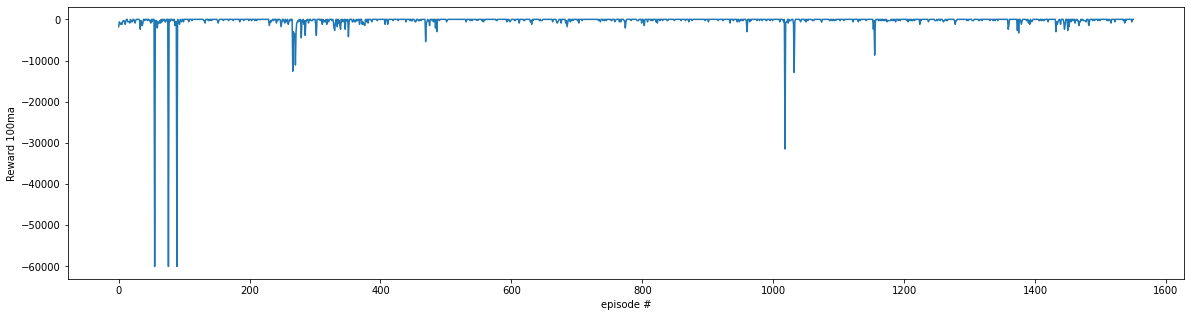

<Figure size 1440x360 with 0 Axes>

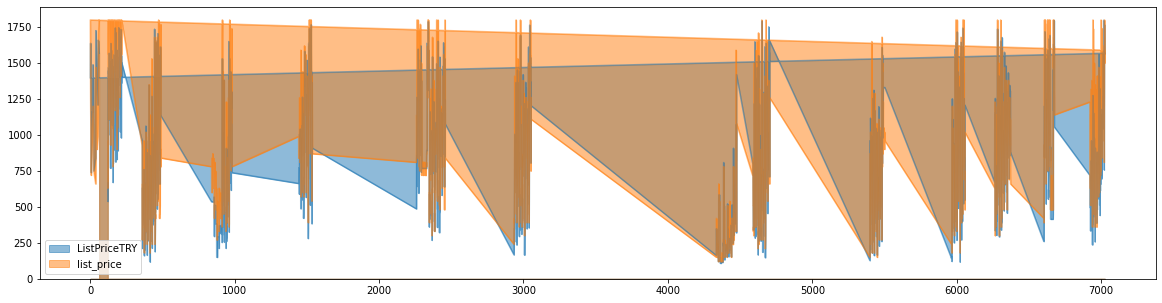



\|
*Number of Sales:  14
*Mean Absolute Error:  225.6280800979559
*Mean Absolute Percentage Error  16.210274846145573
*Mean of Recommended List Prices: 1182.857142857143
*Mean of Original List Prices: 1308.1460454659214
*Standard Deviation of Recommended List Prices: 390.7473819279106
*Standard Deviation of Original List Prices: 344.29144790628527
|
*Number of Sales:  1551
*Mean Absolute Error:  129.7090576011332
*Mean Absolute Percentage Error  19.555540477699466
*Mean of Recommended List Prices: 865.4738878143133
*Mean of Original List Prices: 787.3060805868882
*Standard Deviation of Recommended List Prices: 443.0998043057323
*Standard Deviation of Original List Prices: 423.606566583867
|
*Number of Sales:  1537
*Mean Absolute Error:  128.8353644879546
*Mean Absolute Percentage Error  19.586011342267952
*Mean of Recommended List Prices: 862.5829538061158
*Mean of Original List Prices: 782.5619299633967
*Standard Deviation of Recommended List Prices: 442.61521986967426
*Standard Dev

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Validation


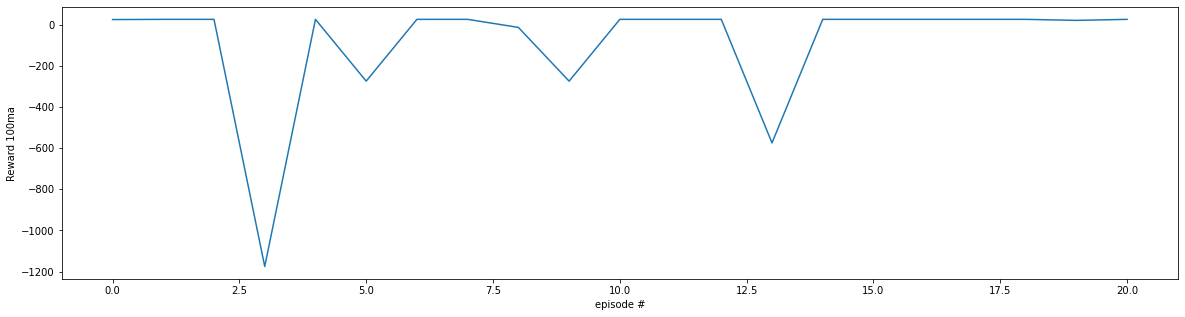

<Figure size 1440x360 with 0 Axes>

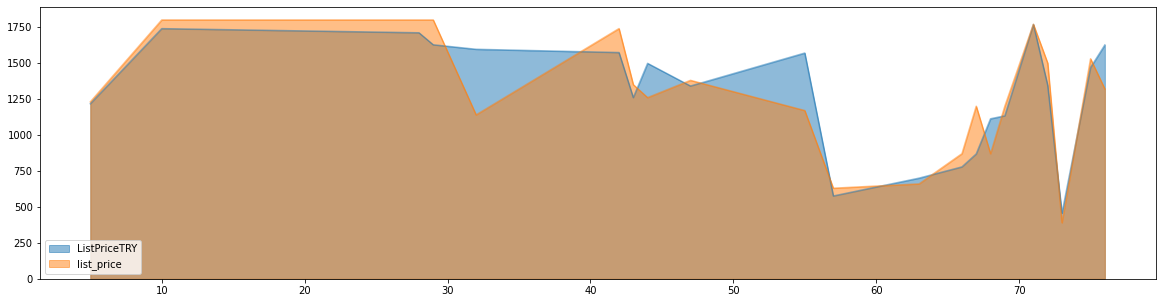

All Dataset


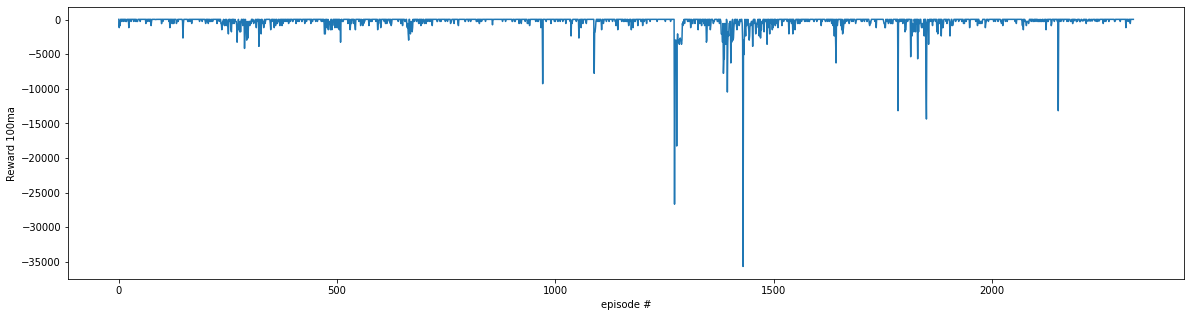

<Figure size 1440x360 with 0 Axes>

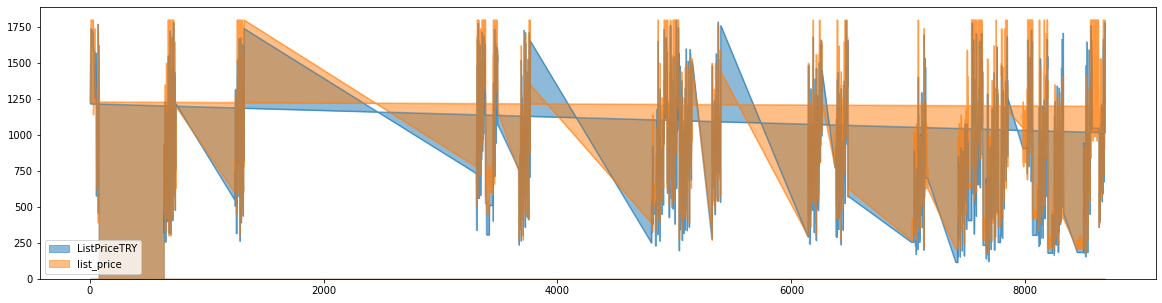



\|
*Number of Sales:  21
*Mean Absolute Error:  149.5526677155543
*Mean Absolute Percentage Error  12.035940907505163
*Mean of Recommended List Prices: 1267.142857142857
*Mean of Original List Prices: 1284.1548015015771
*Standard Deviation of Recommended List Prices: 410.45271173599104
*Standard Deviation of Original List Prices: 401.4039416605529
|
*Number of Sales:  2325
*Mean Absolute Error:  138.1266858020829
*Mean Absolute Percentage Error  22.458266013566817
*Mean of Recommended List Prices: 872.516129032258
*Mean of Original List Prices: 784.41932281262
*Standard Deviation of Recommended List Prices: 432.85973202619977
*Standard Deviation of Original List Prices: 426.151628212223
|
*Number of Sales:  2304
*Mean Absolute Error:  138.0225427377674
*Mean Absolute Percentage Error  22.553261164273103
*Mean of Recommended List Prices: 868.9192708333334
*Mean of Original List Prices: 779.8644421474862
*Standard Deviation of Recommended List Prices: 431.4858398072232
*Standard Deviat

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Validation


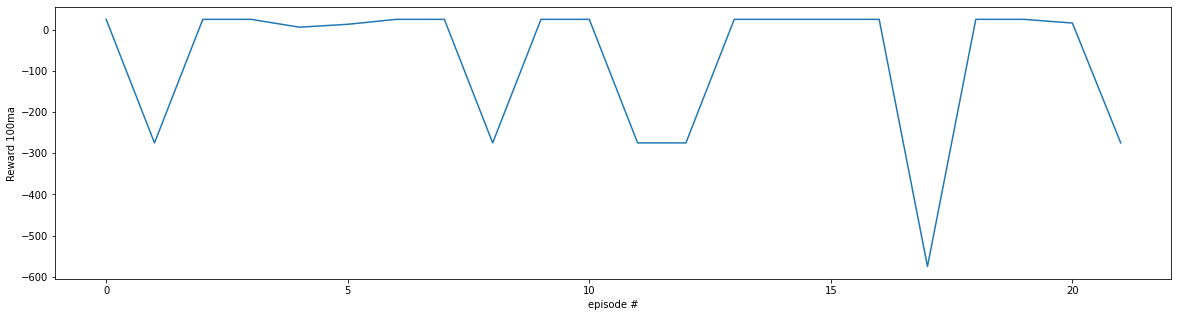

<Figure size 1440x360 with 0 Axes>

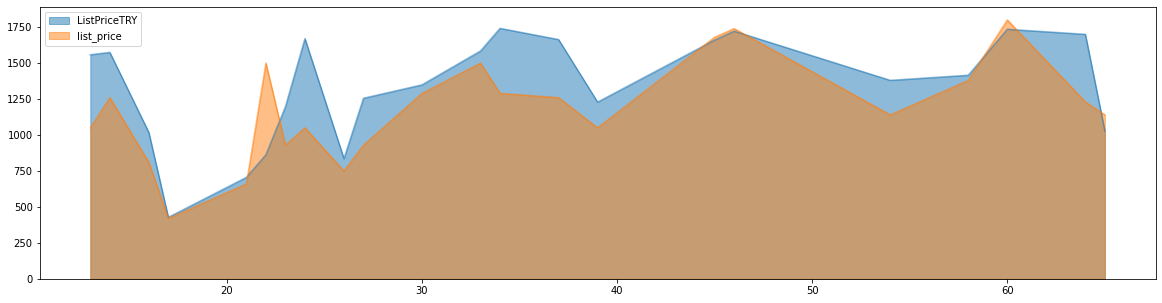

All Dataset


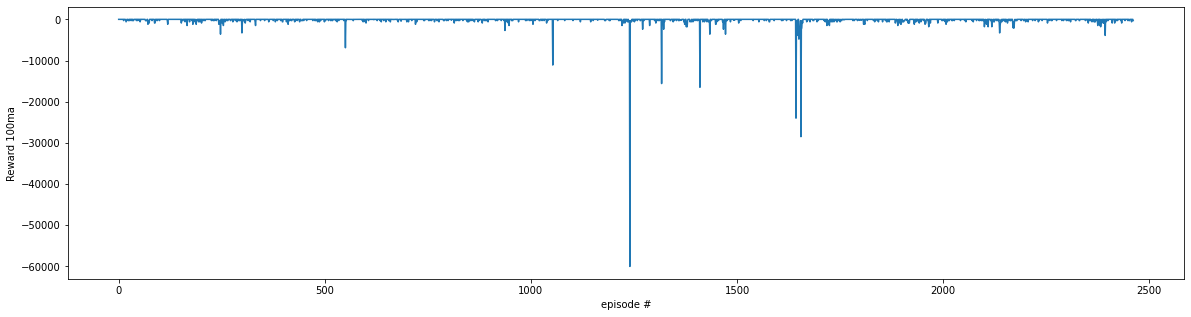

<Figure size 1440x360 with 0 Axes>

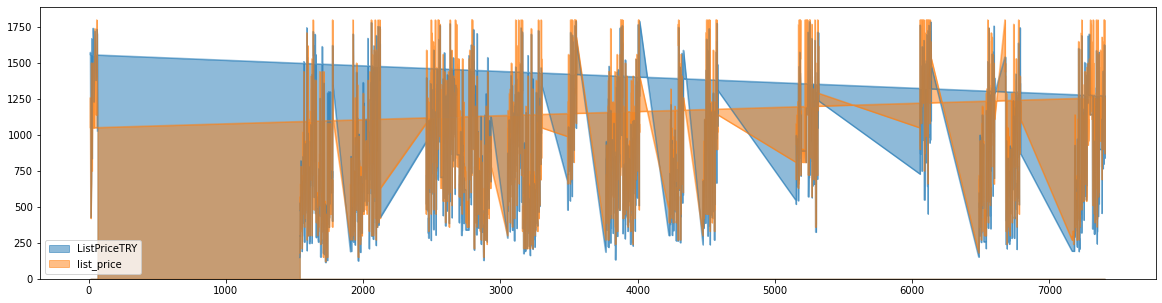



\|
*Number of Sales:  22
*Mean Absolute Error:  234.35736121268977
*Mean Absolute Percentage Error  17.702883637778452
*Mean of Recommended List Prices: 1175.4545454545455
*Mean of Original List Prices: 1332.393561793718
*Standard Deviation of Recommended List Prices: 350.54688257509423
*Standard Deviation of Original List Prices: 380.26034773585593
|
*Number of Sales:  2462
*Mean Absolute Error:  129.35219675686565
*Mean Absolute Percentage Error  19.003076052069137
*Mean of Recommended List Prices: 877.3476848090983
*Mean of Original List Prices: 802.5453604666563
*Standard Deviation of Recommended List Prices: 418.2021564188818
*Standard Deviation of Original List Prices: 405.03026828328177
|
*Number of Sales:  2440
*Mean Absolute Error:  128.40542888062464
*Mean Absolute Percentage Error  19.014799098427503
*Mean of Recommended List Prices: 874.6598360655738
*Mean of Original List Prices: 797.7680406186255
*Standard Deviation of Recommended List Prices: 417.85612150547195
*Standa

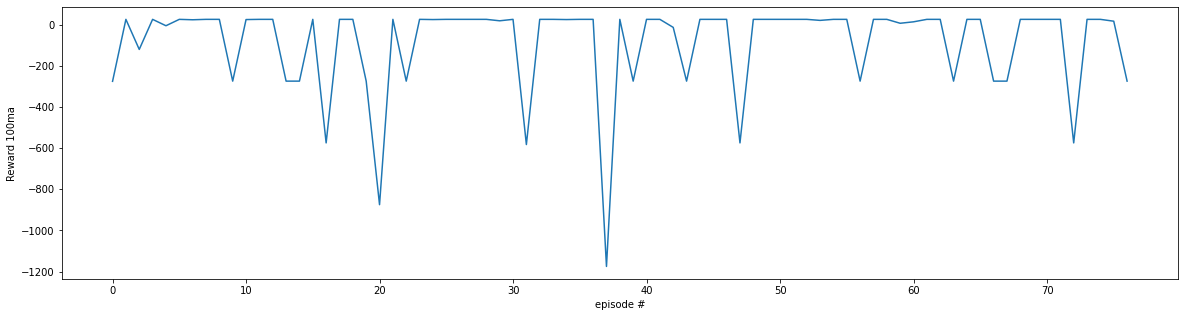

<Figure size 1440x360 with 0 Axes>

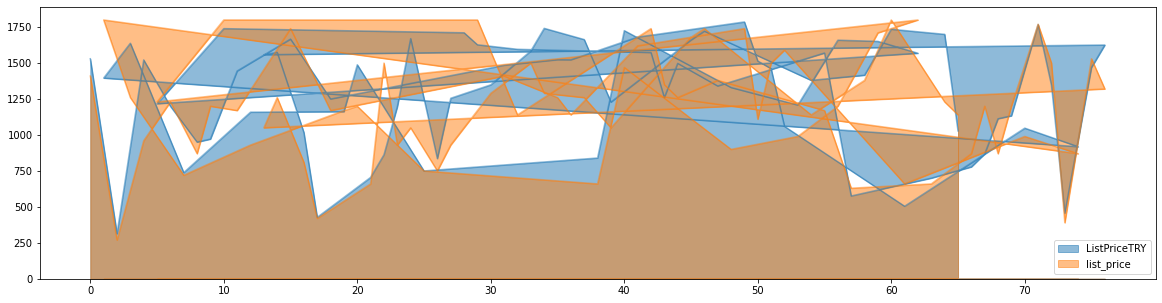

All Dataset


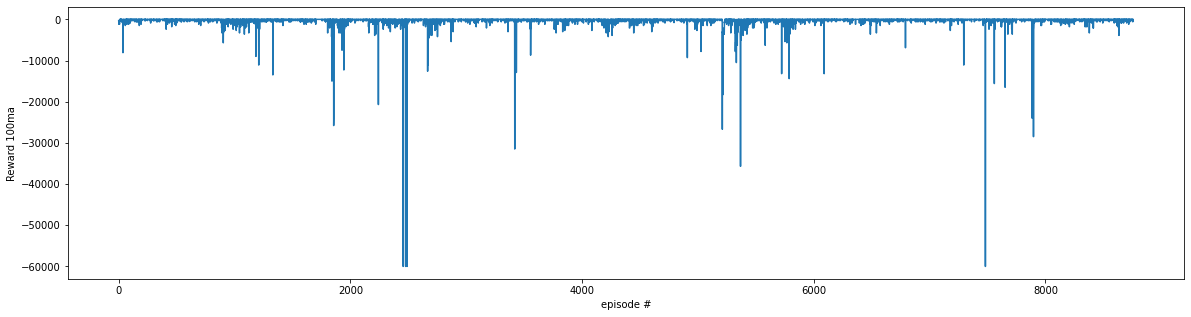

<Figure size 1440x360 with 0 Axes>

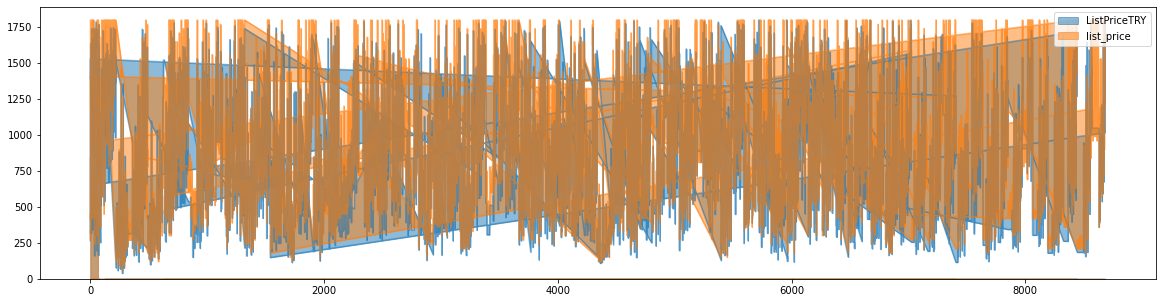



\|
*Number of Sales:  77
*Mean Absolute Error:  194.95223845490526
*Mean Absolute Percentage Error  15.15385294419086
*Mean of Recommended List Prices: 1207.012987012987
*Mean of Original List Prices: 1298.0081701827344
*Standard Deviation of Recommended List Prices: 373.9373186112492
*Standard Deviation of Original List Prices: 376.7728562697773
|
*Number of Sales:  8759
*Mean Absolute Error:  130.1665695230013
*Mean Absolute Percentage Error  20.21134351141604
*Mean of Recommended List Prices: 858.7624158008905
*Mean of Original List Prices: 781.8926231280334
*Standard Deviation of Recommended List Prices: 427.64139413318185
*Standard Deviation of Original List Prices: 417.3028134483606
|
*Number of Sales:  8682
*Mean Absolute Error:  129.59199033528455
*Mean Absolute Percentage Error  20.256198011954666
*Mean of Recommended List Prices: 855.6738078783691
*Mean of Original List Prices: 777.3152334570805
*Standard Deviation of Recommended List Prices: 426.83700555145396
*Standard De

In [ ]:
moving_avg_byrandom_train = []
moving_avg_byrandom_val = []

for i in range(4):
    q_table = q_table_main.copy()
    df_byrandom_train[i].reset_index()
    df_byrandom_train[i], moving_avg_train = RL_proposed(df_byrandom_train[i].shape[0], epsilon, df_byrandom_train[i], q_table)

    moving_avg_byrandom_train.append(moving_avg_train)

    df_byrandom_val[i].reset_index()
    df_byrandom_val[i], moving_avg_val = RL_proposed(df_byrandom_val[i].shape[0], epsilon, df_byrandom_val[i], q_table)

    moving_avg_byrandom_val.append(moving_avg_val)

    moving_avg_random[list(moving_avg_random.keys())[i]] =[moving_avg_train, moving_avg_val]

    draw(moving_avg_train,
         moving_avg_val, 
         np.concatenate([moving_avg_train, moving_avg_val]), 
         df_byrandom_train[i],  
         df_byrandom_val[i])
draw(np.concatenate(moving_avg_byrandom_train),
     np.concatenate(moving_avg_byrandom_val), 
     np.concatenate([np.concatenate(moving_avg_byrandom_train),np.concatenate(moving_avg_byrandom_val)]), 
     pd.concat(df_byrandom_train),
     pd.concat(df_byrandom_val))


In [46]:
np.save('/content/drive/My Drive/Colab Notebooks/dynamic_pricing/results/moving_avg_random.npy',moving_avg_random)